## Connect to G-Drive
I use it for data images and storing model.

In [29]:
base_path='/Users/wenyuehu/Downloads/labeled_data'
model_save_path = base_path + '/model.pt'

In [30]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as T
from PIL import Image
from glob import glob

# load filenames for crt/label images
crt_files = np.array(sorted(glob(base_path + "/scans/*")))
label_files = np.array(sorted(glob(base_path + "/labels/*")))

image_valid_labels = list(range(6))
image_valid_indices = list(range(len(image_valid_labels)))

print(torch.cuda.is_available())
print(torch.cuda.get_arch_list())

use_cuda = torch.cuda.is_available()

device = torch.device("cuda") if use_cuda else torch.device("cpu")
print(f'Selected device: {device}')

False
[]
Selected device: cpu


In [31]:
assert all([
    Image.open(f1).size == Image.open(f2).size
    for f1, f2 in zip(crt_files, label_files)
])

In [32]:
from torch.utils.data import Dataset


class CRTLabeledDataset(Dataset):
    def __init__(self, window_size, stride=None, transforms=None):
        self.wdw_sz = window_size
        self.stride = stride if stride != None else window_size // 4
        self.images = [np.array(Image.open(file).convert("RGB")) for file in crt_files]
        self.labels = [np.array(Image.open(file)) for file in label_files]
        self.image_sizes = [img.shape[:-1] for img in self.images]
        self.images_windows = [((w - self.wdw_sz) // self.stride,
                                (h - self.wdw_sz) // self.stride)
                               for w, h in self.image_sizes]
        self.transforms = transforms

        self.labels_ = [
            np.array([label == l for l in image_valid_labels], dtype="<u1")
            for label in self.labels
        ]

        #  applying transforms if transforms are supplied
        if self.transforms:
            self.images = [self.transforms(image) for image in self.images]

    def __len__(self):
        return sum(wi * hi for wi, hi in self.images_windows)

    def __getitem__(self, idx):
        s = 0
        i = 0
        for wi, hi in self.images_windows:
            s += wi * hi
            if s >= idx:
                s -= wi * hi
                break
            i += 1

        idx -= s
        w, h = self.images_windows[i]
        x0, y0 = (idx % w) * self.stride, (idx // w) * self.stride
        x1, y1 = x0 + self.wdw_sz, y0 + self.wdw_sz

        image = self.images[i]
        label = self.labels_[i]

        return image[:, x0:x1, y0:y1], label[:, x0:x1,
                                             y0:y1], self.labels[i][x0:x1,
                                                                    y0:y1]

In [33]:
image_dims = 256

transforms = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, ), (0.5, )),
])
dataset = CRTLabeledDataset(window_size=image_dims, transforms=transforms)

split_factor = .2
shuffle_dataset = True

dataset_size = len(dataset)
indices = list(range(dataset_size))
if shuffle_dataset:
    np.random.shuffle(indices)
split = int(np.floor(dataset_size * split_factor))
train_indices, test_indices = indices[split:], indices[:split]

In [34]:
torch.cuda.memory_allocated(device)

0

In [35]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 80

# prepare data loaders
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          sampler=test_sampler)

In [36]:
torch.cuda.memory_allocated(device)

0

### Visualize the Data

torch.Size([80, 3, 256, 256]) torch.Size([80, 6, 256, 256]) torch.Size([80, 256, 256])


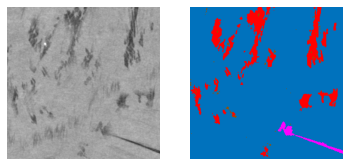

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels, target = next(dataiter)
print(images.shape, labels.shape, target.shape)

# Let's skip all background or unlabeled data
while labels[:, 1:5, :, :].sum() == 0:
    images, labels, _ = next(dataiter)
for i in range(len(images)):
    # get one image from the batch
    img = np.squeeze(images[i])
    lbl = np.squeeze(labels[i])
    if lbl[1:5, :, :].sum() != 0:
        break

img = np.array(img).transpose(1,2,0)
img = ( img + 1 ) / 2

colors = {
    0: [.6, 0.315, 0.],
    1: [0., 1., 0.],
    2: [1., 0., 1.],
    3: [0.929, 0.624, 0.125],
    4: [1., 0., 0.],
    5: [0., 0.4471, 0.7412],
}

_, w, h = lbl.shape
label = np.zeros((w, h, 3), float)
for l, i in zip(image_valid_labels, image_valid_indices):
    label[lbl[i, :, :] == 1, :] = colors[l]


fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes
ax0.axis("off")
ax1.axis("off")
_ = ax0.imshow(img)
_ = ax1.imshow(label)

In [13]:
torch.cuda.memory_allocated(device)

0

In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class FCNClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load pretrained ResNet101 model
        fcn = models.segmentation.fcn_resnet50(weights=models.segmentation.FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
        for param in fcn.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(*list(fcn.children())[:-2])

        # Build decoder for UNet
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1),
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)

        # Classify
        return x

In [50]:
### Set the random seed for reproducible results
# torch.manual_seed(0)

model = FCNClassifier(6)

lr = 1e-5

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

model.to(device)

torch.cuda.memory_allocated(device)

0

---
## Training



In [51]:
import time


### Training function
def train_epoch(model, device, dataloader, criterion, optimizer):
    # Set train mode for both the encoder and the decoder
    #model = torch.compile(model)
    model.train()
    train_loss = 0.0
    batch_time = 0.0
    data_time = 0.0
    trained_size = 0
    end = time.time()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for i, (x, _, target) in enumerate(dataloader):
        # measure data loading time
        data_time += time.time() - end

        # Move tensor to the proper device
        x = x.to(device, non_blocking=True)
        target = target.to(device, dtype=torch.long, non_blocking=True)

        optimizer.zero_grad()

        output = model(x)

        # Evaluate losstarget
        loss = criterion(output, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        trained_size += len(x)

        # measure elapsed time
        batch_time += time.time() - end
        end = time.time()

        if (i + 1) % 25 == 0:
            # Print batch loss
            print(
                '* Average (train_loss: {:.3e}, batch_time: {:.2f}, data_time: {:.2f})'
                .format(train_loss / trained_size, batch_time / (i + 1),
                        data_time / (i + 1)))

    return train_loss / len(dataloader.dataset), batch_time, data_time

In [52]:
### Testing function
def test_epoch(model, device, dataloader, criterion):
    # Set evaluation mode for encoder and decoder
    model.eval()
    val_loss = 0.0
    batch_time = 0.0
    data_time = 0.0
    with torch.no_grad():  # No need to track the gradients
        end = time.time()
        for x, _, target in dataloader:
            # measure data loading time
            data_time += time.time() - end
            # Move tensor to the proper device
            x = x.to(device, non_blocking=True)
            target = target.to(device, dtype=torch.long, non_blocking=True)
            # Encode data
            encoded_data = model.encoder(x)
            # Decode data
            output = model(x)

            loss = criterion(output, target)
            val_loss += loss.item()

            # measure elapsed time
            batch_time += time.time() - end
            end = time.time()

    return val_loss / len(dataloader.dataset), batch_time, data_time

In [46]:

model.load_state_dict(torch.load(model_save_path, map_location=device))

model.to(device)
# print(torch.cuda.memory_summary())


RuntimeError: Error(s) in loading state_dict for FCNClassifier:
	Missing key(s) in state_dict: "ender.0.conv1.weight", "ender.0.bn1.weight", "ender.0.bn1.bias", "ender.0.bn1.running_mean", "ender.0.bn1.running_var", "ender.0.layer1.0.conv1.weight", "ender.0.layer1.0.bn1.weight", "ender.0.layer1.0.bn1.bias", "ender.0.layer1.0.bn1.running_mean", "ender.0.layer1.0.bn1.running_var", "ender.0.layer1.0.conv2.weight", "ender.0.layer1.0.bn2.weight", "ender.0.layer1.0.bn2.bias", "ender.0.layer1.0.bn2.running_mean", "ender.0.layer1.0.bn2.running_var", "ender.0.layer1.0.conv3.weight", "ender.0.layer1.0.bn3.weight", "ender.0.layer1.0.bn3.bias", "ender.0.layer1.0.bn3.running_mean", "ender.0.layer1.0.bn3.running_var", "ender.0.layer1.0.downsample.0.weight", "ender.0.layer1.0.downsample.1.weight", "ender.0.layer1.0.downsample.1.bias", "ender.0.layer1.0.downsample.1.running_mean", "ender.0.layer1.0.downsample.1.running_var", "ender.0.layer1.1.conv1.weight", "ender.0.layer1.1.bn1.weight", "ender.0.layer1.1.bn1.bias", "ender.0.layer1.1.bn1.running_mean", "ender.0.layer1.1.bn1.running_var", "ender.0.layer1.1.conv2.weight", "ender.0.layer1.1.bn2.weight", "ender.0.layer1.1.bn2.bias", "ender.0.layer1.1.bn2.running_mean", "ender.0.layer1.1.bn2.running_var", "ender.0.layer1.1.conv3.weight", "ender.0.layer1.1.bn3.weight", "ender.0.layer1.1.bn3.bias", "ender.0.layer1.1.bn3.running_mean", "ender.0.layer1.1.bn3.running_var", "ender.0.layer1.2.conv1.weight", "ender.0.layer1.2.bn1.weight", "ender.0.layer1.2.bn1.bias", "ender.0.layer1.2.bn1.running_mean", "ender.0.layer1.2.bn1.running_var", "ender.0.layer1.2.conv2.weight", "ender.0.layer1.2.bn2.weight", "ender.0.layer1.2.bn2.bias", "ender.0.layer1.2.bn2.running_mean", "ender.0.layer1.2.bn2.running_var", "ender.0.layer1.2.conv3.weight", "ender.0.layer1.2.bn3.weight", "ender.0.layer1.2.bn3.bias", "ender.0.layer1.2.bn3.running_mean", "ender.0.layer1.2.bn3.running_var", "ender.0.layer2.0.conv1.weight", "ender.0.layer2.0.bn1.weight", "ender.0.layer2.0.bn1.bias", "ender.0.layer2.0.bn1.running_mean", "ender.0.layer2.0.bn1.running_var", "ender.0.layer2.0.conv2.weight", "ender.0.layer2.0.bn2.weight", "ender.0.layer2.0.bn2.bias", "ender.0.layer2.0.bn2.running_mean", "ender.0.layer2.0.bn2.running_var", "ender.0.layer2.0.conv3.weight", "ender.0.layer2.0.bn3.weight", "ender.0.layer2.0.bn3.bias", "ender.0.layer2.0.bn3.running_mean", "ender.0.layer2.0.bn3.running_var", "ender.0.layer2.0.downsample.0.weight", "ender.0.layer2.0.downsample.1.weight", "ender.0.layer2.0.downsample.1.bias", "ender.0.layer2.0.downsample.1.running_mean", "ender.0.layer2.0.downsample.1.running_var", "ender.0.layer2.1.conv1.weight", "ender.0.layer2.1.bn1.weight", "ender.0.layer2.1.bn1.bias", "ender.0.layer2.1.bn1.running_mean", "ender.0.layer2.1.bn1.running_var", "ender.0.layer2.1.conv2.weight", "ender.0.layer2.1.bn2.weight", "ender.0.layer2.1.bn2.bias", "ender.0.layer2.1.bn2.running_mean", "ender.0.layer2.1.bn2.running_var", "ender.0.layer2.1.conv3.weight", "ender.0.layer2.1.bn3.weight", "ender.0.layer2.1.bn3.bias", "ender.0.layer2.1.bn3.running_mean", "ender.0.layer2.1.bn3.running_var", "ender.0.layer2.2.conv1.weight", "ender.0.layer2.2.bn1.weight", "ender.0.layer2.2.bn1.bias", "ender.0.layer2.2.bn1.running_mean", "ender.0.layer2.2.bn1.running_var", "ender.0.layer2.2.conv2.weight", "ender.0.layer2.2.bn2.weight", "ender.0.layer2.2.bn2.bias", "ender.0.layer2.2.bn2.running_mean", "ender.0.layer2.2.bn2.running_var", "ender.0.layer2.2.conv3.weight", "ender.0.layer2.2.bn3.weight", "ender.0.layer2.2.bn3.bias", "ender.0.layer2.2.bn3.running_mean", "ender.0.layer2.2.bn3.running_var", "ender.0.layer2.3.conv1.weight", "ender.0.layer2.3.bn1.weight", "ender.0.layer2.3.bn1.bias", "ender.0.layer2.3.bn1.running_mean", "ender.0.layer2.3.bn1.running_var", "ender.0.layer2.3.conv2.weight", "ender.0.layer2.3.bn2.weight", "ender.0.layer2.3.bn2.bias", "ender.0.layer2.3.bn2.running_mean", "ender.0.layer2.3.bn2.running_var", "ender.0.layer2.3.conv3.weight", "ender.0.layer2.3.bn3.weight", "ender.0.layer2.3.bn3.bias", "ender.0.layer2.3.bn3.running_mean", "ender.0.layer2.3.bn3.running_var", "ender.0.layer3.0.conv1.weight", "ender.0.layer3.0.bn1.weight", "ender.0.layer3.0.bn1.bias", "ender.0.layer3.0.bn1.running_mean", "ender.0.layer3.0.bn1.running_var", "ender.0.layer3.0.conv2.weight", "ender.0.layer3.0.bn2.weight", "ender.0.layer3.0.bn2.bias", "ender.0.layer3.0.bn2.running_mean", "ender.0.layer3.0.bn2.running_var", "ender.0.layer3.0.conv3.weight", "ender.0.layer3.0.bn3.weight", "ender.0.layer3.0.bn3.bias", "ender.0.layer3.0.bn3.running_mean", "ender.0.layer3.0.bn3.running_var", "ender.0.layer3.0.downsample.0.weight", "ender.0.layer3.0.downsample.1.weight", "ender.0.layer3.0.downsample.1.bias", "ender.0.layer3.0.downsample.1.running_mean", "ender.0.layer3.0.downsample.1.running_var", "ender.0.layer3.1.conv1.weight", "ender.0.layer3.1.bn1.weight", "ender.0.layer3.1.bn1.bias", "ender.0.layer3.1.bn1.running_mean", "ender.0.layer3.1.bn1.running_var", "ender.0.layer3.1.conv2.weight", "ender.0.layer3.1.bn2.weight", "ender.0.layer3.1.bn2.bias", "ender.0.layer3.1.bn2.running_mean", "ender.0.layer3.1.bn2.running_var", "ender.0.layer3.1.conv3.weight", "ender.0.layer3.1.bn3.weight", "ender.0.layer3.1.bn3.bias", "ender.0.layer3.1.bn3.running_mean", "ender.0.layer3.1.bn3.running_var", "ender.0.layer3.2.conv1.weight", "ender.0.layer3.2.bn1.weight", "ender.0.layer3.2.bn1.bias", "ender.0.layer3.2.bn1.running_mean", "ender.0.layer3.2.bn1.running_var", "ender.0.layer3.2.conv2.weight", "ender.0.layer3.2.bn2.weight", "ender.0.layer3.2.bn2.bias", "ender.0.layer3.2.bn2.running_mean", "ender.0.layer3.2.bn2.running_var", "ender.0.layer3.2.conv3.weight", "ender.0.layer3.2.bn3.weight", "ender.0.layer3.2.bn3.bias", "ender.0.layer3.2.bn3.running_mean", "ender.0.layer3.2.bn3.running_var", "ender.0.layer3.3.conv1.weight", "ender.0.layer3.3.bn1.weight", "ender.0.layer3.3.bn1.bias", "ender.0.layer3.3.bn1.running_mean", "ender.0.layer3.3.bn1.running_var", "ender.0.layer3.3.conv2.weight", "ender.0.layer3.3.bn2.weight", "ender.0.layer3.3.bn2.bias", "ender.0.layer3.3.bn2.running_mean", "ender.0.layer3.3.bn2.running_var", "ender.0.layer3.3.conv3.weight", "ender.0.layer3.3.bn3.weight", "ender.0.layer3.3.bn3.bias", "ender.0.layer3.3.bn3.running_mean", "ender.0.layer3.3.bn3.running_var", "ender.0.layer3.4.conv1.weight", "ender.0.layer3.4.bn1.weight", "ender.0.layer3.4.bn1.bias", "ender.0.layer3.4.bn1.running_mean", "ender.0.layer3.4.bn1.running_var", "ender.0.layer3.4.conv2.weight", "ender.0.layer3.4.bn2.weight", "ender.0.layer3.4.bn2.bias", "ender.0.layer3.4.bn2.running_mean", "ender.0.layer3.4.bn2.running_var", "ender.0.layer3.4.conv3.weight", "ender.0.layer3.4.bn3.weight", "ender.0.layer3.4.bn3.bias", "ender.0.layer3.4.bn3.running_mean", "ender.0.layer3.4.bn3.running_var", "ender.0.layer3.5.conv1.weight", "ender.0.layer3.5.bn1.weight", "ender.0.layer3.5.bn1.bias", "ender.0.layer3.5.bn1.running_mean", "ender.0.layer3.5.bn1.running_var", "ender.0.layer3.5.conv2.weight", "ender.0.layer3.5.bn2.weight", "ender.0.layer3.5.bn2.bias", "ender.0.layer3.5.bn2.running_mean", "ender.0.layer3.5.bn2.running_var", "ender.0.layer3.5.conv3.weight", "ender.0.layer3.5.bn3.weight", "ender.0.layer3.5.bn3.bias", "ender.0.layer3.5.bn3.running_mean", "ender.0.layer3.5.bn3.running_var", "ender.0.layer4.0.conv1.weight", "ender.0.layer4.0.bn1.weight", "ender.0.layer4.0.bn1.bias", "ender.0.layer4.0.bn1.running_mean", "ender.0.layer4.0.bn1.running_var", "ender.0.layer4.0.conv2.weight", "ender.0.layer4.0.bn2.weight", "ender.0.layer4.0.bn2.bias", "ender.0.layer4.0.bn2.running_mean", "ender.0.layer4.0.bn2.running_var", "ender.0.layer4.0.conv3.weight", "ender.0.layer4.0.bn3.weight", "ender.0.layer4.0.bn3.bias", "ender.0.layer4.0.bn3.running_mean", "ender.0.layer4.0.bn3.running_var", "ender.0.layer4.0.downsample.0.weight", "ender.0.layer4.0.downsample.1.weight", "ender.0.layer4.0.downsample.1.bias", "ender.0.layer4.0.downsample.1.running_mean", "ender.0.layer4.0.downsample.1.running_var", "ender.0.layer4.1.conv1.weight", "ender.0.layer4.1.bn1.weight", "ender.0.layer4.1.bn1.bias", "ender.0.layer4.1.bn1.running_mean", "ender.0.layer4.1.bn1.running_var", "ender.0.layer4.1.conv2.weight", "ender.0.layer4.1.bn2.weight", "ender.0.layer4.1.bn2.bias", "ender.0.layer4.1.bn2.running_mean", "ender.0.layer4.1.bn2.running_var", "ender.0.layer4.1.conv3.weight", "ender.0.layer4.1.bn3.weight", "ender.0.layer4.1.bn3.bias", "ender.0.layer4.1.bn3.running_mean", "ender.0.layer4.1.bn3.running_var", "ender.0.layer4.2.conv1.weight", "ender.0.layer4.2.bn1.weight", "ender.0.layer4.2.bn1.bias", "ender.0.layer4.2.bn1.running_mean", "ender.0.layer4.2.bn1.running_var", "ender.0.layer4.2.conv2.weight", "ender.0.layer4.2.bn2.weight", "ender.0.layer4.2.bn2.bias", "ender.0.layer4.2.bn2.running_mean", "ender.0.layer4.2.bn2.running_var", "ender.0.layer4.2.conv3.weight", "ender.0.layer4.2.bn3.weight", "ender.0.layer4.2.bn3.bias", "ender.0.layer4.2.bn3.running_mean", "ender.0.layer4.2.bn3.running_var". 
	Unexpected key(s) in state_dict: "encoder.0.weight", "encoder.1.weight", "encoder.1.bias", "encoder.1.running_mean", "encoder.1.running_var", "encoder.1.num_batches_tracked", "encoder.4.0.conv1.weight", "encoder.4.0.bn1.weight", "encoder.4.0.bn1.bias", "encoder.4.0.bn1.running_mean", "encoder.4.0.bn1.running_var", "encoder.4.0.bn1.num_batches_tracked", "encoder.4.0.conv2.weight", "encoder.4.0.bn2.weight", "encoder.4.0.bn2.bias", "encoder.4.0.bn2.running_mean", "encoder.4.0.bn2.running_var", "encoder.4.0.bn2.num_batches_tracked", "encoder.4.0.conv3.weight", "encoder.4.0.bn3.weight", "encoder.4.0.bn3.bias", "encoder.4.0.bn3.running_mean", "encoder.4.0.bn3.running_var", "encoder.4.0.bn3.num_batches_tracked", "encoder.4.0.downsample.0.weight", "encoder.4.0.downsample.1.weight", "encoder.4.0.downsample.1.bias", "encoder.4.0.downsample.1.running_mean", "encoder.4.0.downsample.1.running_var", "encoder.4.0.downsample.1.num_batches_tracked", "encoder.4.1.conv1.weight", "encoder.4.1.bn1.weight", "encoder.4.1.bn1.bias", "encoder.4.1.bn1.running_mean", "encoder.4.1.bn1.running_var", "encoder.4.1.bn1.num_batches_tracked", "encoder.4.1.conv2.weight", "encoder.4.1.bn2.weight", "encoder.4.1.bn2.bias", "encoder.4.1.bn2.running_mean", "encoder.4.1.bn2.running_var", "encoder.4.1.bn2.num_batches_tracked", "encoder.4.1.conv3.weight", "encoder.4.1.bn3.weight", "encoder.4.1.bn3.bias", "encoder.4.1.bn3.running_mean", "encoder.4.1.bn3.running_var", "encoder.4.1.bn3.num_batches_tracked", "encoder.4.2.conv1.weight", "encoder.4.2.bn1.weight", "encoder.4.2.bn1.bias", "encoder.4.2.bn1.running_mean", "encoder.4.2.bn1.running_var", "encoder.4.2.bn1.num_batches_tracked", "encoder.4.2.conv2.weight", "encoder.4.2.bn2.weight", "encoder.4.2.bn2.bias", "encoder.4.2.bn2.running_mean", "encoder.4.2.bn2.running_var", "encoder.4.2.bn2.num_batches_tracked", "encoder.4.2.conv3.weight", "encoder.4.2.bn3.weight", "encoder.4.2.bn3.bias", "encoder.4.2.bn3.running_mean", "encoder.4.2.bn3.running_var", "encoder.4.2.bn3.num_batches_tracked", "encoder.5.0.conv1.weight", "encoder.5.0.bn1.weight", "encoder.5.0.bn1.bias", "encoder.5.0.bn1.running_mean", "encoder.5.0.bn1.running_var", "encoder.5.0.bn1.num_batches_tracked", "encoder.5.0.conv2.weight", "encoder.5.0.bn2.weight", "encoder.5.0.bn2.bias", "encoder.5.0.bn2.running_mean", "encoder.5.0.bn2.running_var", "encoder.5.0.bn2.num_batches_tracked", "encoder.5.0.conv3.weight", "encoder.5.0.bn3.weight", "encoder.5.0.bn3.bias", "encoder.5.0.bn3.running_mean", "encoder.5.0.bn3.running_var", "encoder.5.0.bn3.num_batches_tracked", "encoder.5.0.downsample.0.weight", "encoder.5.0.downsample.1.weight", "encoder.5.0.downsample.1.bias", "encoder.5.0.downsample.1.running_mean", "encoder.5.0.downsample.1.running_var", "encoder.5.0.downsample.1.num_batches_tracked", "encoder.5.1.conv1.weight", "encoder.5.1.bn1.weight", "encoder.5.1.bn1.bias", "encoder.5.1.bn1.running_mean", "encoder.5.1.bn1.running_var", "encoder.5.1.bn1.num_batches_tracked", "encoder.5.1.conv2.weight", "encoder.5.1.bn2.weight", "encoder.5.1.bn2.bias", "encoder.5.1.bn2.running_mean", "encoder.5.1.bn2.running_var", "encoder.5.1.bn2.num_batches_tracked", "encoder.5.1.conv3.weight", "encoder.5.1.bn3.weight", "encoder.5.1.bn3.bias", "encoder.5.1.bn3.running_mean", "encoder.5.1.bn3.running_var", "encoder.5.1.bn3.num_batches_tracked", "encoder.5.2.conv1.weight", "encoder.5.2.bn1.weight", "encoder.5.2.bn1.bias", "encoder.5.2.bn1.running_mean", "encoder.5.2.bn1.running_var", "encoder.5.2.bn1.num_batches_tracked", "encoder.5.2.conv2.weight", "encoder.5.2.bn2.weight", "encoder.5.2.bn2.bias", "encoder.5.2.bn2.running_mean", "encoder.5.2.bn2.running_var", "encoder.5.2.bn2.num_batches_tracked", "encoder.5.2.conv3.weight", "encoder.5.2.bn3.weight", "encoder.5.2.bn3.bias", "encoder.5.2.bn3.running_mean", "encoder.5.2.bn3.running_var", "encoder.5.2.bn3.num_batches_tracked", "encoder.5.3.conv1.weight", "encoder.5.3.bn1.weight", "encoder.5.3.bn1.bias", "encoder.5.3.bn1.running_mean", "encoder.5.3.bn1.running_var", "encoder.5.3.bn1.num_batches_tracked", "encoder.5.3.conv2.weight", "encoder.5.3.bn2.weight", "encoder.5.3.bn2.bias", "encoder.5.3.bn2.running_mean", "encoder.5.3.bn2.running_var", "encoder.5.3.bn2.num_batches_tracked", "encoder.5.3.conv3.weight", "encoder.5.3.bn3.weight", "encoder.5.3.bn3.bias", "encoder.5.3.bn3.running_mean", "encoder.5.3.bn3.running_var", "encoder.5.3.bn3.num_batches_tracked", "encoder.6.0.conv1.weight", "encoder.6.0.bn1.weight", "encoder.6.0.bn1.bias", "encoder.6.0.bn1.running_mean", "encoder.6.0.bn1.running_var", "encoder.6.0.bn1.num_batches_tracked", "encoder.6.0.conv2.weight", "encoder.6.0.bn2.weight", "encoder.6.0.bn2.bias", "encoder.6.0.bn2.running_mean", "encoder.6.0.bn2.running_var", "encoder.6.0.bn2.num_batches_tracked", "encoder.6.0.conv3.weight", "encoder.6.0.bn3.weight", "encoder.6.0.bn3.bias", "encoder.6.0.bn3.running_mean", "encoder.6.0.bn3.running_var", "encoder.6.0.bn3.num_batches_tracked", "encoder.6.0.downsample.0.weight", "encoder.6.0.downsample.1.weight", "encoder.6.0.downsample.1.bias", "encoder.6.0.downsample.1.running_mean", "encoder.6.0.downsample.1.running_var", "encoder.6.0.downsample.1.num_batches_tracked", "encoder.6.1.conv1.weight", "encoder.6.1.bn1.weight", "encoder.6.1.bn1.bias", "encoder.6.1.bn1.running_mean", "encoder.6.1.bn1.running_var", "encoder.6.1.bn1.num_batches_tracked", "encoder.6.1.conv2.weight", "encoder.6.1.bn2.weight", "encoder.6.1.bn2.bias", "encoder.6.1.bn2.running_mean", "encoder.6.1.bn2.running_var", "encoder.6.1.bn2.num_batches_tracked", "encoder.6.1.conv3.weight", "encoder.6.1.bn3.weight", "encoder.6.1.bn3.bias", "encoder.6.1.bn3.running_mean", "encoder.6.1.bn3.running_var", "encoder.6.1.bn3.num_batches_tracked", "encoder.6.2.conv1.weight", "encoder.6.2.bn1.weight", "encoder.6.2.bn1.bias", "encoder.6.2.bn1.running_mean", "encoder.6.2.bn1.running_var", "encoder.6.2.bn1.num_batches_tracked", "encoder.6.2.conv2.weight", "encoder.6.2.bn2.weight", "encoder.6.2.bn2.bias", "encoder.6.2.bn2.running_mean", "encoder.6.2.bn2.running_var", "encoder.6.2.bn2.num_batches_tracked", "encoder.6.2.conv3.weight", "encoder.6.2.bn3.weight", "encoder.6.2.bn3.bias", "encoder.6.2.bn3.running_mean", "encoder.6.2.bn3.running_var", "encoder.6.2.bn3.num_batches_tracked", "encoder.6.3.conv1.weight", "encoder.6.3.bn1.weight", "encoder.6.3.bn1.bias", "encoder.6.3.bn1.running_mean", "encoder.6.3.bn1.running_var", "encoder.6.3.bn1.num_batches_tracked", "encoder.6.3.conv2.weight", "encoder.6.3.bn2.weight", "encoder.6.3.bn2.bias", "encoder.6.3.bn2.running_mean", "encoder.6.3.bn2.running_var", "encoder.6.3.bn2.num_batches_tracked", "encoder.6.3.conv3.weight", "encoder.6.3.bn3.weight", "encoder.6.3.bn3.bias", "encoder.6.3.bn3.running_mean", "encoder.6.3.bn3.running_var", "encoder.6.3.bn3.num_batches_tracked", "encoder.6.4.conv1.weight", "encoder.6.4.bn1.weight", "encoder.6.4.bn1.bias", "encoder.6.4.bn1.running_mean", "encoder.6.4.bn1.running_var", "encoder.6.4.bn1.num_batches_tracked", "encoder.6.4.conv2.weight", "encoder.6.4.bn2.weight", "encoder.6.4.bn2.bias", "encoder.6.4.bn2.running_mean", "encoder.6.4.bn2.running_var", "encoder.6.4.bn2.num_batches_tracked", "encoder.6.4.conv3.weight", "encoder.6.4.bn3.weight", "encoder.6.4.bn3.bias", "encoder.6.4.bn3.running_mean", "encoder.6.4.bn3.running_var", "encoder.6.4.bn3.num_batches_tracked", "encoder.6.5.conv1.weight", "encoder.6.5.bn1.weight", "encoder.6.5.bn1.bias", "encoder.6.5.bn1.running_mean", "encoder.6.5.bn1.running_var", "encoder.6.5.bn1.num_batches_tracked", "encoder.6.5.conv2.weight", "encoder.6.5.bn2.weight", "encoder.6.5.bn2.bias", "encoder.6.5.bn2.running_mean", "encoder.6.5.bn2.running_var", "encoder.6.5.bn2.num_batches_tracked", "encoder.6.5.conv3.weight", "encoder.6.5.bn3.weight", "encoder.6.5.bn3.bias", "encoder.6.5.bn3.running_mean", "encoder.6.5.bn3.running_var", "encoder.6.5.bn3.num_batches_tracked", "encoder.6.6.conv1.weight", "encoder.6.6.bn1.weight", "encoder.6.6.bn1.bias", "encoder.6.6.bn1.running_mean", "encoder.6.6.bn1.running_var", "encoder.6.6.bn1.num_batches_tracked", "encoder.6.6.conv2.weight", "encoder.6.6.bn2.weight", "encoder.6.6.bn2.bias", "encoder.6.6.bn2.running_mean", "encoder.6.6.bn2.running_var", "encoder.6.6.bn2.num_batches_tracked", "encoder.6.6.conv3.weight", "encoder.6.6.bn3.weight", "encoder.6.6.bn3.bias", "encoder.6.6.bn3.running_mean", "encoder.6.6.bn3.running_var", "encoder.6.6.bn3.num_batches_tracked", "encoder.6.7.conv1.weight", "encoder.6.7.bn1.weight", "encoder.6.7.bn1.bias", "encoder.6.7.bn1.running_mean", "encoder.6.7.bn1.running_var", "encoder.6.7.bn1.num_batches_tracked", "encoder.6.7.conv2.weight", "encoder.6.7.bn2.weight", "encoder.6.7.bn2.bias", "encoder.6.7.bn2.running_mean", "encoder.6.7.bn2.running_var", "encoder.6.7.bn2.num_batches_tracked", "encoder.6.7.conv3.weight", "encoder.6.7.bn3.weight", "encoder.6.7.bn3.bias", "encoder.6.7.bn3.running_mean", "encoder.6.7.bn3.running_var", "encoder.6.7.bn3.num_batches_tracked", "encoder.6.8.conv1.weight", "encoder.6.8.bn1.weight", "encoder.6.8.bn1.bias", "encoder.6.8.bn1.running_mean", "encoder.6.8.bn1.running_var", "encoder.6.8.bn1.num_batches_tracked", "encoder.6.8.conv2.weight", "encoder.6.8.bn2.weight", "encoder.6.8.bn2.bias", "encoder.6.8.bn2.running_mean", "encoder.6.8.bn2.running_var", "encoder.6.8.bn2.num_batches_tracked", "encoder.6.8.conv3.weight", "encoder.6.8.bn3.weight", "encoder.6.8.bn3.bias", "encoder.6.8.bn3.running_mean", "encoder.6.8.bn3.running_var", "encoder.6.8.bn3.num_batches_tracked", "encoder.6.9.conv1.weight", "encoder.6.9.bn1.weight", "encoder.6.9.bn1.bias", "encoder.6.9.bn1.running_mean", "encoder.6.9.bn1.running_var", "encoder.6.9.bn1.num_batches_tracked", "encoder.6.9.conv2.weight", "encoder.6.9.bn2.weight", "encoder.6.9.bn2.bias", "encoder.6.9.bn2.running_mean", "encoder.6.9.bn2.running_var", "encoder.6.9.bn2.num_batches_tracked", "encoder.6.9.conv3.weight", "encoder.6.9.bn3.weight", "encoder.6.9.bn3.bias", "encoder.6.9.bn3.running_mean", "encoder.6.9.bn3.running_var", "encoder.6.9.bn3.num_batches_tracked", "encoder.6.10.conv1.weight", "encoder.6.10.bn1.weight", "encoder.6.10.bn1.bias", "encoder.6.10.bn1.running_mean", "encoder.6.10.bn1.running_var", "encoder.6.10.bn1.num_batches_tracked", "encoder.6.10.conv2.weight", "encoder.6.10.bn2.weight", "encoder.6.10.bn2.bias", "encoder.6.10.bn2.running_mean", "encoder.6.10.bn2.running_var", "encoder.6.10.bn2.num_batches_tracked", "encoder.6.10.conv3.weight", "encoder.6.10.bn3.weight", "encoder.6.10.bn3.bias", "encoder.6.10.bn3.running_mean", "encoder.6.10.bn3.running_var", "encoder.6.10.bn3.num_batches_tracked", "encoder.6.11.conv1.weight", "encoder.6.11.bn1.weight", "encoder.6.11.bn1.bias", "encoder.6.11.bn1.running_mean", "encoder.6.11.bn1.running_var", "encoder.6.11.bn1.num_batches_tracked", "encoder.6.11.conv2.weight", "encoder.6.11.bn2.weight", "encoder.6.11.bn2.bias", "encoder.6.11.bn2.running_mean", "encoder.6.11.bn2.running_var", "encoder.6.11.bn2.num_batches_tracked", "encoder.6.11.conv3.weight", "encoder.6.11.bn3.weight", "encoder.6.11.bn3.bias", "encoder.6.11.bn3.running_mean", "encoder.6.11.bn3.running_var", "encoder.6.11.bn3.num_batches_tracked", "encoder.6.12.conv1.weight", "encoder.6.12.bn1.weight", "encoder.6.12.bn1.bias", "encoder.6.12.bn1.running_mean", "encoder.6.12.bn1.running_var", "encoder.6.12.bn1.num_batches_tracked", "encoder.6.12.conv2.weight", "encoder.6.12.bn2.weight", "encoder.6.12.bn2.bias", "encoder.6.12.bn2.running_mean", "encoder.6.12.bn2.running_var", "encoder.6.12.bn2.num_batches_tracked", "encoder.6.12.conv3.weight", "encoder.6.12.bn3.weight", "encoder.6.12.bn3.bias", "encoder.6.12.bn3.running_mean", "encoder.6.12.bn3.running_var", "encoder.6.12.bn3.num_batches_tracked", "encoder.6.13.conv1.weight", "encoder.6.13.bn1.weight", "encoder.6.13.bn1.bias", "encoder.6.13.bn1.running_mean", "encoder.6.13.bn1.running_var", "encoder.6.13.bn1.num_batches_tracked", "encoder.6.13.conv2.weight", "encoder.6.13.bn2.weight", "encoder.6.13.bn2.bias", "encoder.6.13.bn2.running_mean", "encoder.6.13.bn2.running_var", "encoder.6.13.bn2.num_batches_tracked", "encoder.6.13.conv3.weight", "encoder.6.13.bn3.weight", "encoder.6.13.bn3.bias", "encoder.6.13.bn3.running_mean", "encoder.6.13.bn3.running_var", "encoder.6.13.bn3.num_batches_tracked", "encoder.6.14.conv1.weight", "encoder.6.14.bn1.weight", "encoder.6.14.bn1.bias", "encoder.6.14.bn1.running_mean", "encoder.6.14.bn1.running_var", "encoder.6.14.bn1.num_batches_tracked", "encoder.6.14.conv2.weight", "encoder.6.14.bn2.weight", "encoder.6.14.bn2.bias", "encoder.6.14.bn2.running_mean", "encoder.6.14.bn2.running_var", "encoder.6.14.bn2.num_batches_tracked", "encoder.6.14.conv3.weight", "encoder.6.14.bn3.weight", "encoder.6.14.bn3.bias", "encoder.6.14.bn3.running_mean", "encoder.6.14.bn3.running_var", "encoder.6.14.bn3.num_batches_tracked", "encoder.6.15.conv1.weight", "encoder.6.15.bn1.weight", "encoder.6.15.bn1.bias", "encoder.6.15.bn1.running_mean", "encoder.6.15.bn1.running_var", "encoder.6.15.bn1.num_batches_tracked", "encoder.6.15.conv2.weight", "encoder.6.15.bn2.weight", "encoder.6.15.bn2.bias", "encoder.6.15.bn2.running_mean", "encoder.6.15.bn2.running_var", "encoder.6.15.bn2.num_batches_tracked", "encoder.6.15.conv3.weight", "encoder.6.15.bn3.weight", "encoder.6.15.bn3.bias", "encoder.6.15.bn3.running_mean", "encoder.6.15.bn3.running_var", "encoder.6.15.bn3.num_batches_tracked", "encoder.6.16.conv1.weight", "encoder.6.16.bn1.weight", "encoder.6.16.bn1.bias", "encoder.6.16.bn1.running_mean", "encoder.6.16.bn1.running_var", "encoder.6.16.bn1.num_batches_tracked", "encoder.6.16.conv2.weight", "encoder.6.16.bn2.weight", "encoder.6.16.bn2.bias", "encoder.6.16.bn2.running_mean", "encoder.6.16.bn2.running_var", "encoder.6.16.bn2.num_batches_tracked", "encoder.6.16.conv3.weight", "encoder.6.16.bn3.weight", "encoder.6.16.bn3.bias", "encoder.6.16.bn3.running_mean", "encoder.6.16.bn3.running_var", "encoder.6.16.bn3.num_batches_tracked", "encoder.6.17.conv1.weight", "encoder.6.17.bn1.weight", "encoder.6.17.bn1.bias", "encoder.6.17.bn1.running_mean", "encoder.6.17.bn1.running_var", "encoder.6.17.bn1.num_batches_tracked", "encoder.6.17.conv2.weight", "encoder.6.17.bn2.weight", "encoder.6.17.bn2.bias", "encoder.6.17.bn2.running_mean", "encoder.6.17.bn2.running_var", "encoder.6.17.bn2.num_batches_tracked", "encoder.6.17.conv3.weight", "encoder.6.17.bn3.weight", "encoder.6.17.bn3.bias", "encoder.6.17.bn3.running_mean", "encoder.6.17.bn3.running_var", "encoder.6.17.bn3.num_batches_tracked", "encoder.6.18.conv1.weight", "encoder.6.18.bn1.weight", "encoder.6.18.bn1.bias", "encoder.6.18.bn1.running_mean", "encoder.6.18.bn1.running_var", "encoder.6.18.bn1.num_batches_tracked", "encoder.6.18.conv2.weight", "encoder.6.18.bn2.weight", "encoder.6.18.bn2.bias", "encoder.6.18.bn2.running_mean", "encoder.6.18.bn2.running_var", "encoder.6.18.bn2.num_batches_tracked", "encoder.6.18.conv3.weight", "encoder.6.18.bn3.weight", "encoder.6.18.bn3.bias", "encoder.6.18.bn3.running_mean", "encoder.6.18.bn3.running_var", "encoder.6.18.bn3.num_batches_tracked", "encoder.6.19.conv1.weight", "encoder.6.19.bn1.weight", "encoder.6.19.bn1.bias", "encoder.6.19.bn1.running_mean", "encoder.6.19.bn1.running_var", "encoder.6.19.bn1.num_batches_tracked", "encoder.6.19.conv2.weight", "encoder.6.19.bn2.weight", "encoder.6.19.bn2.bias", "encoder.6.19.bn2.running_mean", "encoder.6.19.bn2.running_var", "encoder.6.19.bn2.num_batches_tracked", "encoder.6.19.conv3.weight", "encoder.6.19.bn3.weight", "encoder.6.19.bn3.bias", "encoder.6.19.bn3.running_mean", "encoder.6.19.bn3.running_var", "encoder.6.19.bn3.num_batches_tracked", "encoder.6.20.conv1.weight", "encoder.6.20.bn1.weight", "encoder.6.20.bn1.bias", "encoder.6.20.bn1.running_mean", "encoder.6.20.bn1.running_var", "encoder.6.20.bn1.num_batches_tracked", "encoder.6.20.conv2.weight", "encoder.6.20.bn2.weight", "encoder.6.20.bn2.bias", "encoder.6.20.bn2.running_mean", "encoder.6.20.bn2.running_var", "encoder.6.20.bn2.num_batches_tracked", "encoder.6.20.conv3.weight", "encoder.6.20.bn3.weight", "encoder.6.20.bn3.bias", "encoder.6.20.bn3.running_mean", "encoder.6.20.bn3.running_var", "encoder.6.20.bn3.num_batches_tracked", "encoder.6.21.conv1.weight", "encoder.6.21.bn1.weight", "encoder.6.21.bn1.bias", "encoder.6.21.bn1.running_mean", "encoder.6.21.bn1.running_var", "encoder.6.21.bn1.num_batches_tracked", "encoder.6.21.conv2.weight", "encoder.6.21.bn2.weight", "encoder.6.21.bn2.bias", "encoder.6.21.bn2.running_mean", "encoder.6.21.bn2.running_var", "encoder.6.21.bn2.num_batches_tracked", "encoder.6.21.conv3.weight", "encoder.6.21.bn3.weight", "encoder.6.21.bn3.bias", "encoder.6.21.bn3.running_mean", "encoder.6.21.bn3.running_var", "encoder.6.21.bn3.num_batches_tracked", "encoder.6.22.conv1.weight", "encoder.6.22.bn1.weight", "encoder.6.22.bn1.bias", "encoder.6.22.bn1.running_mean", "encoder.6.22.bn1.running_var", "encoder.6.22.bn1.num_batches_tracked", "encoder.6.22.conv2.weight", "encoder.6.22.bn2.weight", "encoder.6.22.bn2.bias", "encoder.6.22.bn2.running_mean", "encoder.6.22.bn2.running_var", "encoder.6.22.bn2.num_batches_tracked", "encoder.6.22.conv3.weight", "encoder.6.22.bn3.weight", "encoder.6.22.bn3.bias", "encoder.6.22.bn3.running_mean", "encoder.6.22.bn3.running_var", "encoder.6.22.bn3.num_batches_tracked", "encoder.7.0.conv1.weight", "encoder.7.0.bn1.weight", "encoder.7.0.bn1.bias", "encoder.7.0.bn1.running_mean", "encoder.7.0.bn1.running_var", "encoder.7.0.bn1.num_batches_tracked", "encoder.7.0.conv2.weight", "encoder.7.0.bn2.weight", "encoder.7.0.bn2.bias", "encoder.7.0.bn2.running_mean", "encoder.7.0.bn2.running_var", "encoder.7.0.bn2.num_batches_tracked", "encoder.7.0.conv3.weight", "encoder.7.0.bn3.weight", "encoder.7.0.bn3.bias", "encoder.7.0.bn3.running_mean", "encoder.7.0.bn3.running_var", "encoder.7.0.bn3.num_batches_tracked", "encoder.7.0.downsample.0.weight", "encoder.7.0.downsample.1.weight", "encoder.7.0.downsample.1.bias", "encoder.7.0.downsample.1.running_mean", "encoder.7.0.downsample.1.running_var", "encoder.7.0.downsample.1.num_batches_tracked", "encoder.7.1.conv1.weight", "encoder.7.1.bn1.weight", "encoder.7.1.bn1.bias", "encoder.7.1.bn1.running_mean", "encoder.7.1.bn1.running_var", "encoder.7.1.bn1.num_batches_tracked", "encoder.7.1.conv2.weight", "encoder.7.1.bn2.weight", "encoder.7.1.bn2.bias", "encoder.7.1.bn2.running_mean", "encoder.7.1.bn2.running_var", "encoder.7.1.bn2.num_batches_tracked", "encoder.7.1.conv3.weight", "encoder.7.1.bn3.weight", "encoder.7.1.bn3.bias", "encoder.7.1.bn3.running_mean", "encoder.7.1.bn3.running_var", "encoder.7.1.bn3.num_batches_tracked", "encoder.7.2.conv1.weight", "encoder.7.2.bn1.weight", "encoder.7.2.bn1.bias", "encoder.7.2.bn1.running_mean", "encoder.7.2.bn1.running_var", "encoder.7.2.bn1.num_batches_tracked", "encoder.7.2.conv2.weight", "encoder.7.2.bn2.weight", "encoder.7.2.bn2.bias", "encoder.7.2.bn2.running_mean", "encoder.7.2.bn2.running_var", "encoder.7.2.bn2.num_batches_tracked", "encoder.7.2.conv3.weight", "encoder.7.2.bn3.weight", "encoder.7.2.bn3.bias", "encoder.7.2.bn3.running_mean", "encoder.7.2.bn3.running_var", "encoder.7.2.bn3.num_batches_tracked". 

In [53]:
val_loss_min = 100

num_epochs = 500

for epoch in range(num_epochs):
    train_loss, train_batch_time, train_data_time = train_epoch(
        model, device, train_loader, criterion, optim)
    val_loss, val_batch_time, val_data_time = test_epoch(
        model, device, test_loader, criterion)
    print(
        'Epoch {}/{}:  train_loss {:.3e}, val_loss {:.3e}, train_batch_time {:.2f}, train_data_time {:.2f}, val_batch_time {:.2f}, val_data_time {:.2f}'
        .format(epoch + 1, num_epochs, train_loss, val_loss, train_batch_time,
                train_data_time, val_batch_time, val_data_time))
    
    if val_loss < val_loss_min:
        print('Validation loss decreased ({:.3e} --> {:.3e}).  Saving model ...'.format(val_loss_min, val_loss))
        torch.save(model.state_dict(), model_save_path)
        val_loss_min = val_loss


TypeError: conv_transpose2d(): argument 'input' (position 1) must be Tensor, not collections.OrderedDict

## Checking out the results


In [21]:
model.load_state_dict(torch.load(model_save_path, map_location=device))

<All keys matched successfully>

(10, 256, 256, 3)
(10, 256, 256, 3)
(10, 256, 256, 3)
1.0 0.09019607


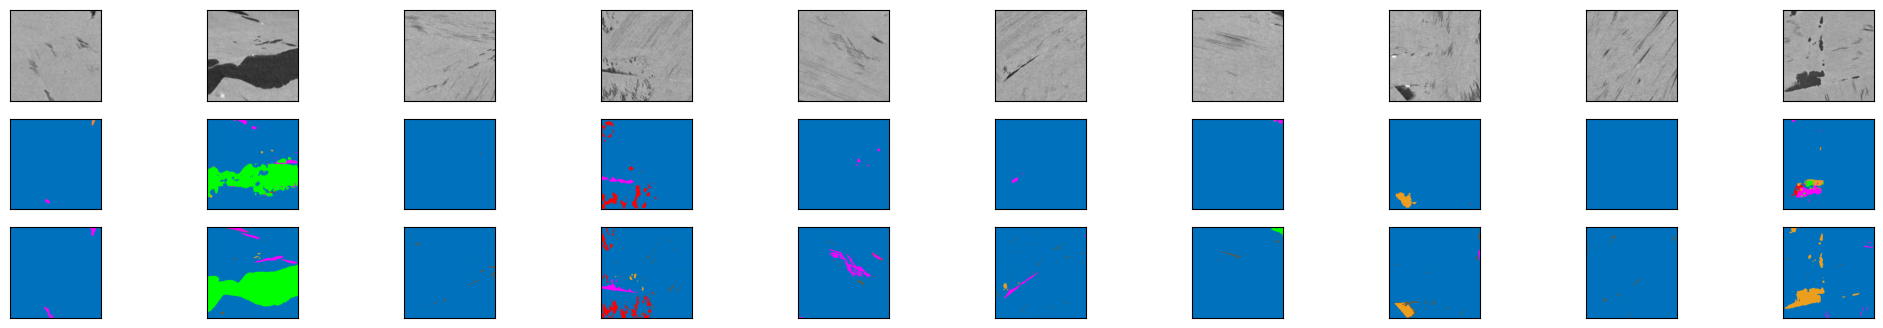

In [19]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

images, labels = images[:10], labels[:10]

model.cpu()

label_images = []
for lbl in labels:
    lbl = np.squeeze(lbl)
    _, w, h = lbl.shape
    label = np.zeros((w, h, 3), float)
    for l, i in zip(image_valid_labels, image_valid_indices):
        label[lbl[i, :, :] == 1, :] = colors[l]
    label_images.append(label)

# fig, axes = plt.subplots(1, 2)
# ax0, ax1 = axes
# ax0.imshow(img, cmap='gray')
# ax1.imshow(label)

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy().transpose(0,2,3,1)
output = output.detach().numpy()

output_images = []
for img in output:
    img = np.squeeze(img)
    _, w, h = img.shape
    res = np.zeros((w, h, 3), float)
    t = T.ToTensor()(img)
    A = torch.argmax(t, dim=1).T
    for l, i in zip(image_valid_labels, image_valid_indices):
        res[A == i, :] = colors[l]
    output_images.append(res)

# # output is resized into a batch of iages
# output = output.view(batch_size, 1, 28, 28)
# # use detach when it's an output that requires_grad
# output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=3,
                         ncols=len(images),
                         sharex=True,
                         sharey=True,
                         figsize=(25, 4))

# input images on top row, reconstructions on bottom
for arr in [images, output_images, label_images]:
  print(np.array(arr).shape)

images = (images+1)/2  # tensor values are between -1 and +1

for imgs, row in zip([images, output_images, label_images], axes):
    for img, ax in zip(imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)